# Downloading Data and Data Preprocessing

Download dataset using the given link in the README.

Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as pt

df = pd.read_csv('matches.csv')

C:\Users\minim\AppData\Local\Temp\ipykernel_19468\518126727.py:6: DtypeWarning: Columns (0: subdivision) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('matches.csv')


Data preprocessing

In [2]:

# 1. Create Team Indices
# We pool all unique teams from both home and away columns
all_teams = pd.unique(df[['home_team_id', 'away_team_id']].values.ravel())
team_map = {team: i for i, team in enumerate(all_teams)}
num_teams = len(all_teams)

# 2. Create Season Indices (Temporal Index)
# Map years (1888-2023) to 0-135
seasons = sorted(df['season'].unique())
season_map = {year: i for i, year in enumerate(seasons)}
num_seasons = len(seasons)

# 3. Map the dataframe
df['home_idx'] = df['home_team_id'].map(team_map).values.astype("int64")
df['away_idx'] = df['away_team_id'].map(team_map).values.astype("int64")
df['season_idx'] = df['season'].map(season_map).values.astype("int64")

df['home_idx'] = df['home_idx'].astype("int64")
df['away_idx'] = df['away_idx'].astype("int64")
df['season_idx'] = df['season_idx'].astype("int64")

# Target variable: Home Team Margin
y = df['home_team_score_margin'].values

# Research Question 1

## Defining Model

Model definition and sampling


In [5]:
with pm.Model() as model_rq1:
    # --- DATA INPUTS ---
    # home_idx = pm.Data("home_idx", df['home_idx'])
    # away_idx = pm.Data("away_idx", df['away_idx'])
    # season_idx = pm.Data("season_idx", df['season_idx'])
    # Run this before defining the model
    home_idx = df['home_idx'].values.astype("int64")
    away_idx = df['away_idx'].values.astype("int64")
    season_idx = df['season_idx'].values.astype("int64")



    # --- HYPER-PRIORS (Level 3) ---
    sigma_u = pm.Exponential("sigma_u", 1.0)        # Spread of team abilities
    sigma_drift = pm.Exponential("sigma_drift", 1.0) # Speed of HA evolution
    sigma_delta = pm.Exponential("sigma_delta", 1.0) # Spread of team HA offsets

    # --- GROUP-LEVEL PRIORS (Level 2) ---

    # 1. Team Latent Ability (u)
    # Mean-centered at 0
    # u = pm.Normal("u", mu=0, sigma=sigma_u, shape=num_teams)

    u_offset = pm.Normal("u_offset", mu=0, sigma=1, shape=num_teams)
    u = pm.Deterministic("u", u_offset * sigma_u)

    # 2. Temporal Home Advantage (h_t) - THE EVOLUTION
    # We use a Random Walk so that Season T depends on Season T-1
    ha_temporal = pm.GaussianRandomWalk("ha_temporal",
                                        sigma=sigma_drift,
                                        shape=num_seasons)



    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_offset * sigma_delta)

    # 3. Team-Specific HA Offset (delta) - THE "delta" EFFECT
    # Professor's suggested "Random Slopes"
    # ha_team_offset = pm.Normal("ha_team_offset", mu=0, sigma=sigma_delta, shape=num_teams)

    # --- DATA MODEL / LIKELIHOOD (Level 1) ---

    # Linear Predictor: (Home Ability - Away Ability) + Temporal HA + Team HA Offset
    mu = (u[home_idx] - u[away_idx]) + \
         ha_temporal[season_idx] + \
         ha_team_offset[home_idx]

    # Standard deviation of the match margin noise
    eps = pm.HalfNormal("eps", sigma=2.0)

    # Likelihood
    margin = pm.Normal("margin", mu=mu, sigma=eps, observed=y)

    # --- SAMPLING ---
    # Using 2000 samples for the posterior
    trace = pm.sample(1000, tune=1000, return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
                      chains = 2,target_accept=0.9)

c:\Users\minim\miniconda3\envs\e_horiz\Lib\site-packages\pymc\distributions\timeseries.py:291: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_subtensor_merge
ERROR (pytensor.graph.rewriting.basic): node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\minim\miniconda3\envs\e_horiz\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\minim\miniconda3\envs\e_horiz\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 341 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Results

Evolution of home advantage

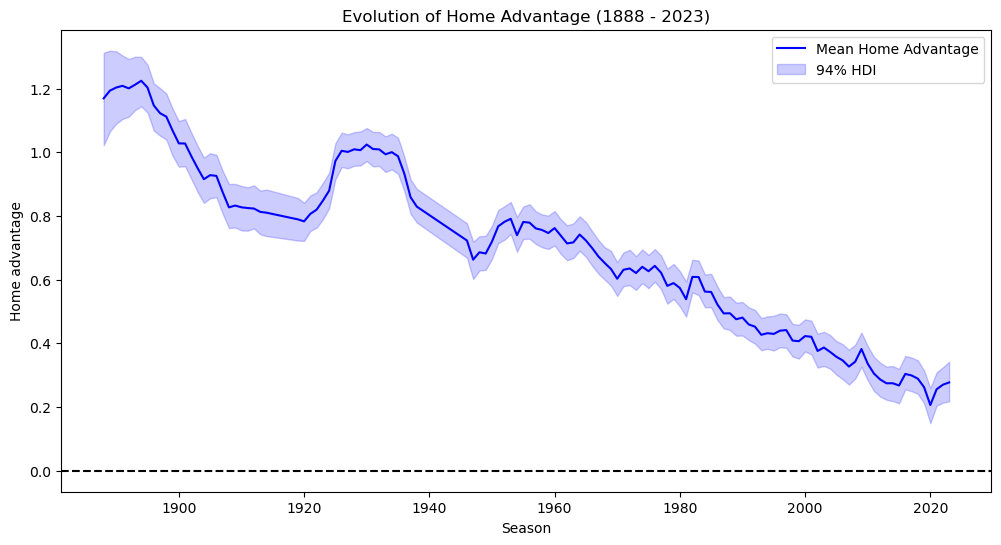

In [6]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

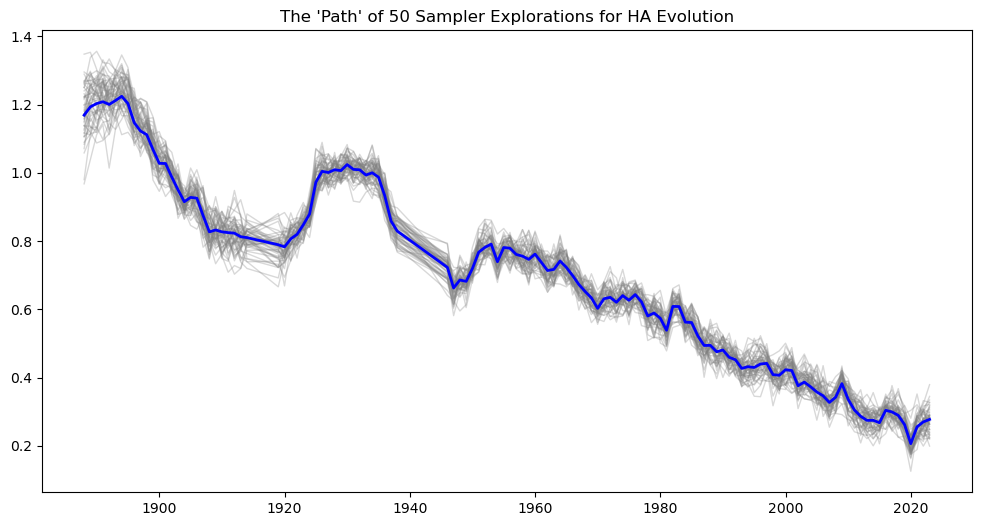

In [7]:
# Extract the first 50 paths (draws) from the first chain
ha_samples = trace.posterior["ha_temporal"].values[0, :50, :]

plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(seasons, ha_samples[i, :], color="gray", alpha=0.3, lw=1)

# Overlay the mean (the 'final' answer)
plt.plot(seasons, post_ha, color="blue", lw=2, label="Posterior Mean")
plt.title("The 'Path' of 50 Sampler Explorations for HA Evolution")
plt.show()

Posterior distribution and NUTS samples of priors and hyperpriors

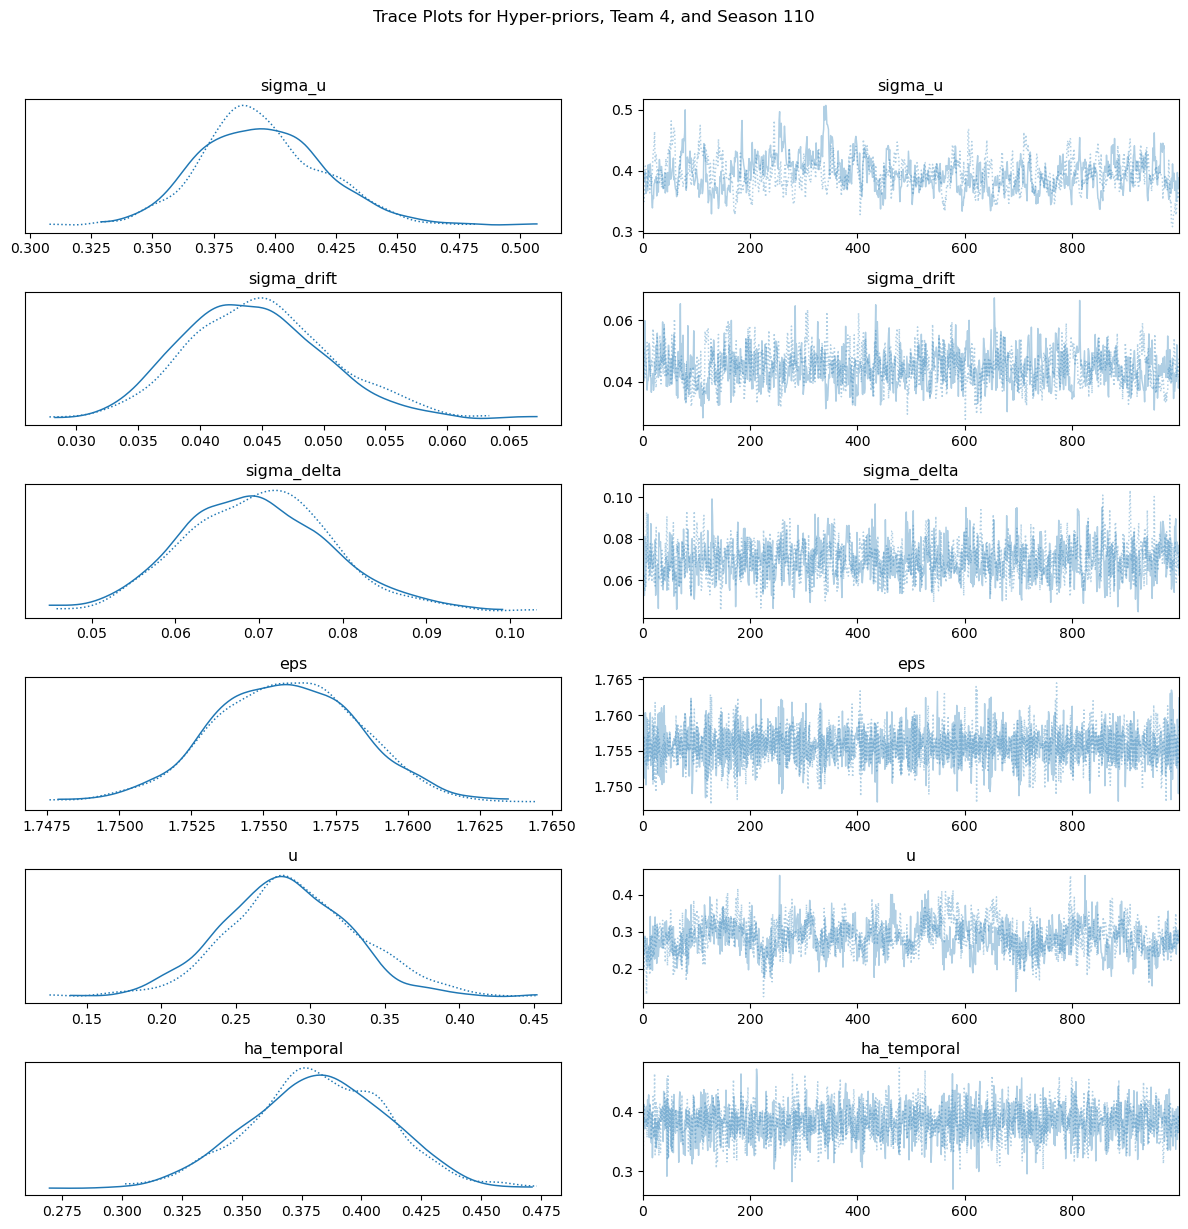

In [10]:
import matplotlib.pyplot as plt

# Define the variables to plot
var_names_to_plot = [
    "sigma_u",
    "sigma_drift",
    "sigma_delta",
    "eps",
    "u",
    "ha_temporal",
]

# Define coordinates for the randomly selected team and season
coords_to_plot = {
    "u_dim_0": [4],
    "ha_temporal_dim_0": [110],
}

# Generate the trace plot
az.plot_trace(trace, var_names=var_names_to_plot, coords=coords_to_plot)

plt.suptitle(f"Trace Plots for Hyper-priors, Team {4}, and Season {110}", y=1.02)
plt.tight_layout()
plt.show()

Convergence diagnostics

In [11]:
summary_all_vars = az.summary(trace, var_names=var_names_to_plot, coords=coords_to_plot)
print(summary_all_vars)

                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_u           0.395  0.027   0.346    0.444      0.003    0.001      96.0   
sigma_drift       0.045  0.006   0.035    0.056      0.000    0.000     504.0   
sigma_delta       0.070  0.009   0.053    0.086      0.000    0.000    1057.0   
eps               1.756  0.003   1.751    1.760      0.000    0.000    4769.0   
u[4]              0.286  0.044   0.197    0.363      0.003    0.001     180.0   
ha_temporal[110]  0.382  0.029   0.326    0.434      0.001    0.001    2160.0   

                  ess_tail  r_hat  
sigma_u              378.0   1.03  
sigma_drift         1016.0   1.01  
sigma_delta         1215.0   1.00  
eps                 1205.0   1.00  
u[4]                 533.0   1.01  
ha_temporal[110]    1667.0   1.00  


Posterior Predictive Checks

In [12]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace, model=model_rq1)

# 2. Calculate RMSE for Margin
home_pred = ppc.posterior_predictive["margin"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((y - home_pred)**2))
print(f"Average error in margin: {rmse_home:.3f}")

# az.plot_ppc(ppc, kind="kde")

Sampling: [margin]


Output()

Average error in margin: 1.755


<Axes: xlabel='margin'>

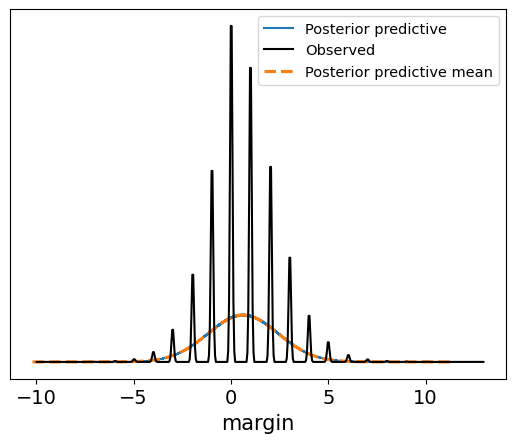

In [13]:
az.plot_ppc(ppc, kind="kde")

Distribution of Residuals

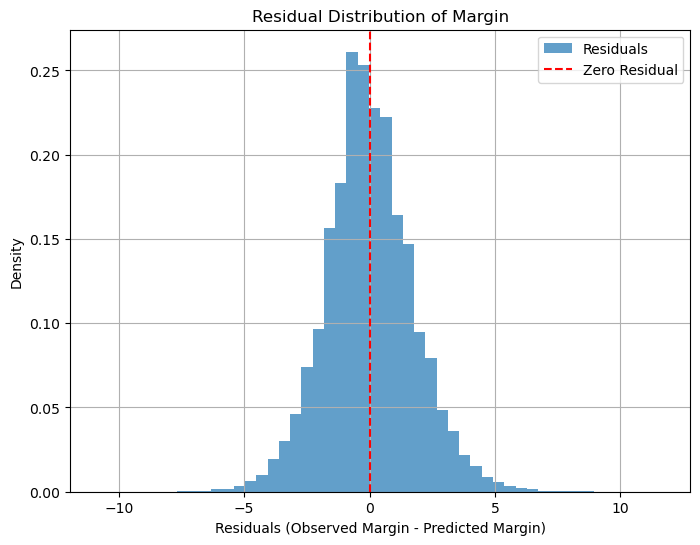

In [14]:
residuals = y - home_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, density=True, alpha=0.7, label='Residuals')
plt.title('Residual Distribution of Margin')
plt.xlabel('Residuals (Observed Margin - Predicted Margin)')
plt.ylabel('Density')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
plt.legend()
plt.grid(True)
plt.show()


## Second Model - Varying Slope

In [15]:


with pm.Model() as model_rq12:
    # --- DATA INPUTS ---
    home_idx = df['home_idx'].values.astype("int64")
    away_idx = df['away_idx'].values.astype("int64")
    season_idx = df['season_idx'].values.astype("int64")

    # --- HYPER-PRIORS (Level 3) ---
    sigma_u = pm.Exponential("sigma_u", 1.0)        # Spread of team abilities
    sigma_drift = pm.Exponential("sigma_drift", 1.0) # Speed of HA evolution
    sigma_delta = pm.Exponential("sigma_delta", 1.0) # Spread of team HA offsets
    sigma_beta_season_slope = pm.Exponential("sigma_beta_season_slope", 1.0) # Spread of random slope for ability difference by season

    # --- GROUP-LEVEL PRIORS (Level 2) ---

    # 1. Team Latent Ability (u)
    u_offset = pm.Normal("u_offset", mu=0, sigma=1, shape=num_teams)
    u_raw = pm.Deterministic("u_raw", u_offset * sigma_u)
    u = pm.Deterministic("u", u_raw - pm.math.mean(u_raw))

    # 2. Temporal Home Advantage (h_t) - THE EVOLUTION
    ha_temporal = pm.GaussianRandomWalk("ha_temporal",
                                        sigma=sigma_drift,
                                        init_dist=pm.Normal.dist(0, 1.0),
                                        shape=num_seasons)

    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    delta_raw = pm.Deterministic("delta_raw", delta_offset * sigma_delta)
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_raw - pm.math.mean(delta_raw))

    # 4. Random slope for ability difference by season
    beta_season_slope = pm.Normal("beta_season_slope", mu=1, sigma=sigma_beta_season_slope, shape=num_seasons)

    # --- DATA MODEL / LIKELIHOOD (Level 1) ---

    # Linear Predictor: (Home Ability - Away Ability) + Temporal HA + Team HA Offset
    mu = (beta_season_slope[season_idx] * (u[home_idx] - u[away_idx])) + \
         ha_temporal[season_idx] + \
         ha_team_offset[home_idx]

    # Standard deviation of the match margin noise
    eps = pm.HalfNormal("eps", sigma=2.0)

    # Likelihood
    margin = pm.Normal("margin", mu=mu, sigma=eps, observed=y)

    # --- SAMPLING ---
    trace2 = pm.sample(1000, tune=1000, target_accept=0.9,
                       return_inferencedata=True,
        idata_kwargs={"log_likelihood": True})


c:\Users\minim\miniconda3\envs\e_horiz\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_subtensor_merge
ERROR (pytensor.graph.rewriting.basic): node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\minim\miniconda3\envs\e_horiz\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1920, i

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1771 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


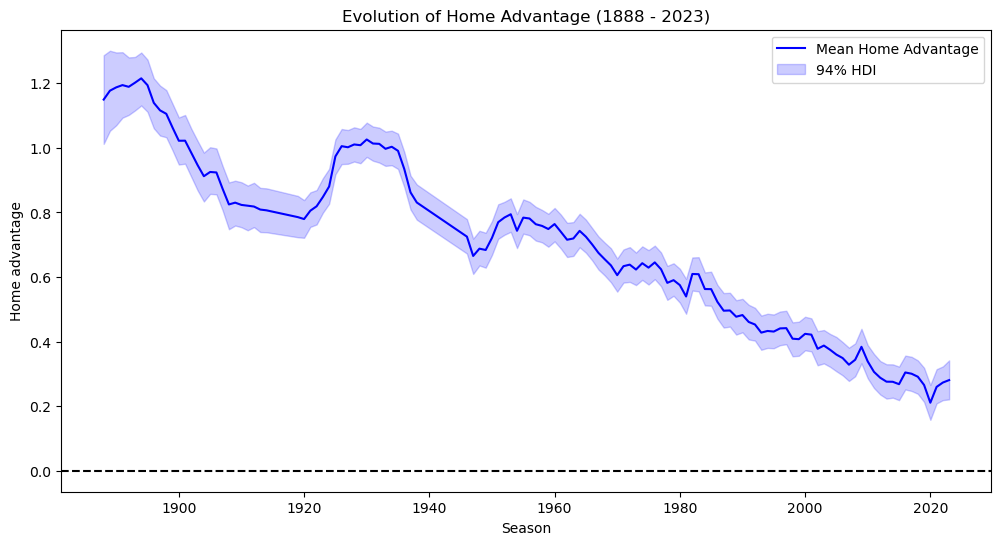

In [16]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace2.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace2).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

Sampling: [margin]


Output()

Average error in home goals: 1.751


<Axes: xlabel='margin'>

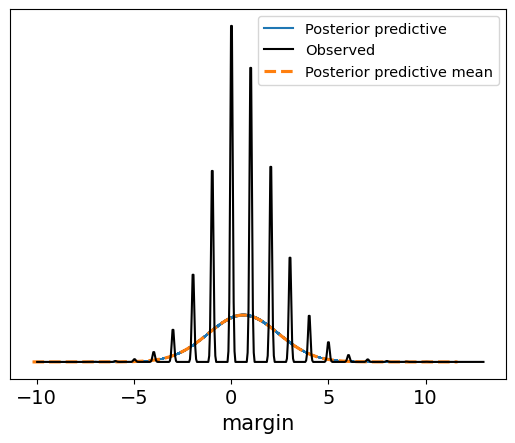

In [17]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace2, model=model_rq12)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["margin"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((y - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

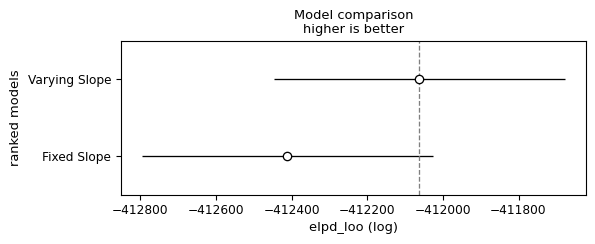

In [18]:
# Create a dictionary of your two models
model_comp = {
    "Fixed Slope": trace,
    "Varying Slope": trace2
}

# 1. Compare them using LOO
comp_df = az.compare(model_comp, ic="loo")

# 2. Visualize the comparison
az.plot_compare(comp_df)

# Research Question 2

## Defining the Model

In [ ]:
# Ensure your target data is ready
home_goals_obs = df['home_team_score'].values.astype("int64")
away_goals_obs = df['away_team_score'].values.astype("int64")
# Reuse your existing indices (h_idx, a_idx, s_idx) from the previous step
home_idx = df['home_idx'].values.astype("int64")
away_idx = df['away_idx'].values.astype("int64")
season_idx = df['season_idx'].values.astype("int64")
with pm.Model() as model_rq2:
    # --- HYPER-PRIORS (Level 3) ---
    # We need separate spreads for Attack and Defense
    sigma_att = pm.Exponential("sigma_att", 1.0)
    sigma_def = pm.Exponential("sigma_def", 1.0)

    # These control the Home Advantage evolution and team specific offsets
    sigma_drift = pm.Exponential("sigma_drift", 1.0)
    sigma_delta = pm.Exponential("sigma_delta", 1.0)

    # Global Intercept (Baseline goal rate for an average game)
    intercept = pm.Normal("intercept", mu=0, sigma=0.5)

    # --- TEAM SKILLS (Level 2) ---
    # 1. Attack Skills (Non-Centered)
    # att_offset = pm.Normal("att_offset", mu=0, sigma=1, shape=num_teams)
    # atts = pm.Deterministic("atts", att_offset * sigma_att)

    att_offset = pm.Normal("att_offset", mu=0.0, sigma=1.0, shape=num_teams)
    atts_raw = att_offset * sigma_att
    # center to enforce identifiability
    atts = pm.Deterministic("atts", atts_raw - atts_raw.mean())

    # 2. Defense Skills (Non-Centered) - Remember: Higher = Weaker Defense
    # def_offset = pm.Normal("def_offset", mu=0, sigma=1, shape=num_teams)
    # defs = pm.Deterministic("defs", def_offset * sigma_def)

    def_offset = pm.Normal("def_offset", mu=0.0, sigma=1.0, shape=num_teams)
    defs_raw = def_offset * sigma_def
    defs = pm.Deterministic("defs", defs_raw - defs_raw.mean())

    # --- HOME ADVANTAGE COMPONENTS ---
    # 1. Temporal Trend (Manual Random Walk to fix int8 error)
    # h_init = pm.Normal("h_init", mu=0, sigma=1.0)
    # h_steps = pm.Normal("h_steps", mu=0, sigma=1.0, shape=num_seasons - 1)
    # ha_temporal = pm.Deterministic("ha_temporal",
    #                                h_init + pm.math.concatenate([[0], pm.math.cumsum(h_steps * sigma_drift)]))
    # ha_temporal = pm.GaussianRandomWalk("ha_temporal",
    #                                     sigma=sigma_drift,
    #                                     shape=num_seasons)

    ha_temporal = pm.GaussianRandomWalk(
        "ha_temporal",
        sigma=sigma_drift,
        init_dist=pm.Normal.dist(0, 1.0),  # <--- This fixes the warning
        shape=num_seasons
    )

    # 2. Team-Specific HA Offset (Random Slopes)
    # delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    # ha_team_offset = pm.Deterministic("ha_team_offset", delta_offset * sigma_delta)

    # 1. Create the raw offsets (Non-Centered Parameterization for speed)
    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    delta_raw = pm.Deterministic("delta_raw", delta_offset * sigma_delta)

    # 2. Apply the sum-to-zero constraint (Centering)
    # This forces the mean of all team offsets to be 0
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_raw - pm.math.mean(delta_raw))
    # --- LINEAR PREDICTORS (Level 1) ---
    # We calculate the Log-Rate (theta) for both sides

    # Home Rate = Intercept + (Time HA + Team HA) + Home Attack + Away Defense
    lambda_h = pm.math.exp(intercept +
                          ha_temporal[season_idx] +
                           ha_team_offset[home_idx]+
                          atts[home_idx] +
                          defs[away_idx])

    # Away Rate = Intercept + Away Attack + Home Defense (No HA terms)
    lambda_a = pm.math.exp(intercept +
                          atts[away_idx] +
                          defs[home_idx])

    # --- LIKELIHOOD ---
    # We treat Home and Away goals as two separate Poisson observations
    # connected by the shared parameters above
    home_points = pm.Poisson("home_points", mu=lambda_h, observed=home_goals_obs)
    away_points = pm.Poisson("away_points", mu=lambda_a, observed=away_goals_obs)

    # --- SAMPLING ---
    trace_rq2 = pm.sample(
    draws=2000,
    tune=2000,
    chains=3,
    target_accept=0.95,
    return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
    nuts_sampler="numpyro")

    # ppc = pm.sample_posterior_predictive(trace_rq2)


Posterior Predictive Checks

Sampling: [away_points, home_points]


Output()

Average error in home goals: 1.384


array([<Axes: xlabel='home_points'>, <Axes: xlabel='away_points'>],
      dtype=object)

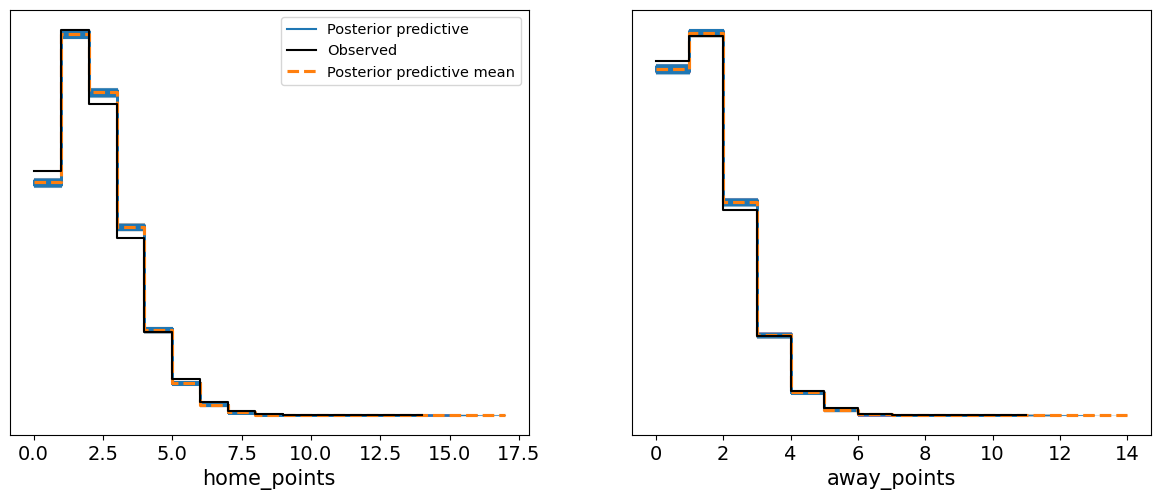

In [5]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace_rq2, model=model_rq2)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["home_points"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((home_goals_obs - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

Posterior Distributions and NUTS samples of Priors and Hyperpriors

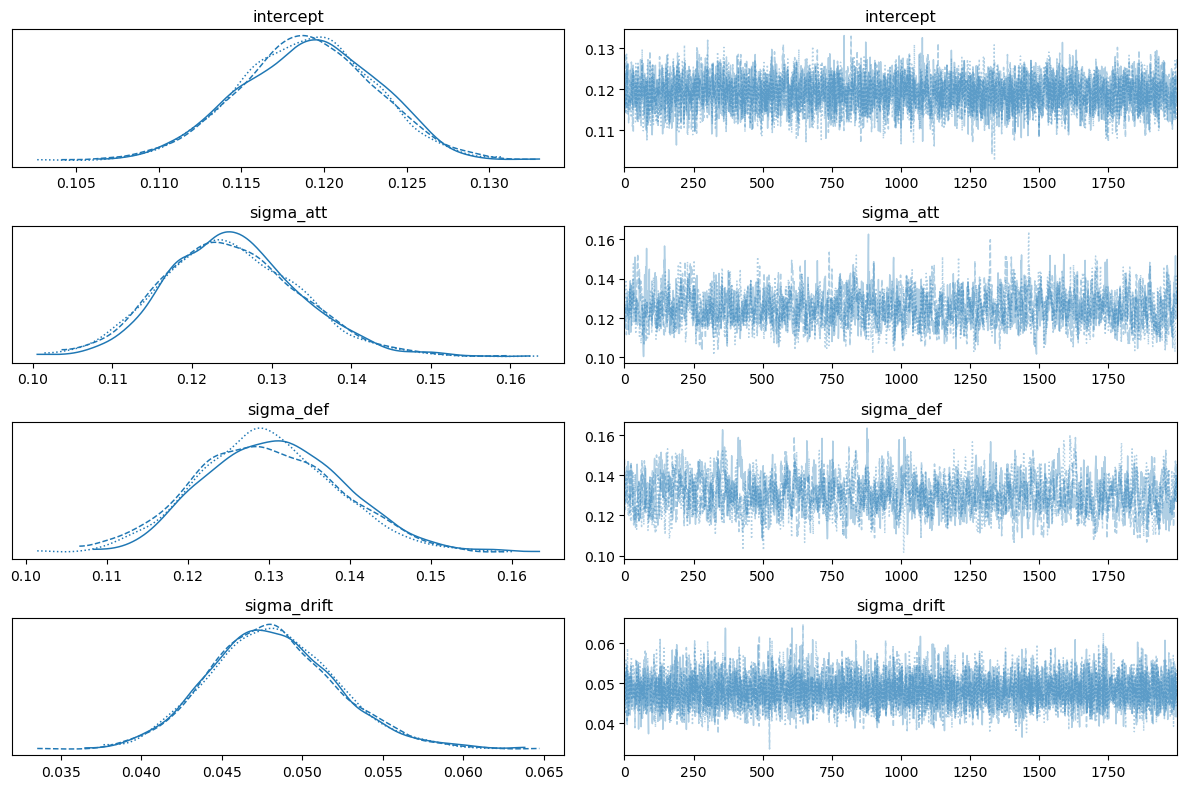

In [7]:
# Usually, we plot just the hyper-priors first so the screen isn't crowded
import matplotlib.pyplot as plt
az.plot_trace(trace_rq2, var_names=["intercept","sigma_att", "sigma_def","sigma_drift"])

# az.plot_forest(trace_rq2, var_names=["att"], combined=True, coords={"att_dim_0": range(10)})
plt.tight_layout()

Convergence Diagnostics

In [8]:
summary = az.summary(trace_rq2, var_names=["intercept","sigma_att", "sigma_def","sigma_drift"])
print(summary)

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept    0.119  0.004   0.112    0.127        0.0      0.0    4168.0   
sigma_att    0.125  0.008   0.110    0.141        0.0      0.0    1105.0   
sigma_def    0.130  0.009   0.113    0.146        0.0      0.0     644.0   
sigma_drift  0.048  0.004   0.041    0.056        0.0      0.0    7465.0   

             ess_tail  r_hat  
intercept      4775.0   1.00  
sigma_att      2114.0   1.00  
sigma_def      1429.0   1.01  
sigma_drift    4739.0   1.00  


## Results

Attributed Variance

In [9]:
atts_samples = trace_rq2.posterior['atts'].values.flatten()
var_atts = np.var(atts_samples)

defs_samples = trace_rq2.posterior['defs'].values.flatten()
var_defs = np.var(defs_samples)

Vlatent = var_atts + var_defs

print(f"Variance of atts: {var_atts:.4f}")
print(f"Variance of defs: {var_defs:.4f}")
print(f"Vlatent (Sum of variances): {Vlatent:.4f}")

ha_temporal_samples = trace_rq2.posterior['ha_temporal'].values.flatten()
var_ha_temporal = np.var(ha_temporal_samples)

ha_team_offset_samples = trace_rq2.posterior['ha_team_offset'].values.flatten()
var_ha_team_offset = np.var(ha_team_offset_samples)
Vhome = var_ha_temporal + var_ha_team_offset
print(f"Variance of ha_temporal: {var_ha_temporal:.4f}")
print(f"Variance of ha_team_offset: {var_ha_team_offset:.4f}")

ha_temporal_samples = trace_rq2.posterior['ha_temporal'].values.flatten()
mean_ha_temporal = np.mean(ha_temporal_samples)
Vhome = (mean_ha_temporal**2) * 0.25

print(f"Mean of ha_temporal: {mean_ha_temporal:.4f}")
print(f"Vhome: {Vhome:.4f}")

ratio = Vhome / (Vhome + Vlatent)
print(f"Ratio Vhome / (Vhome + Vlatent): {ratio:.4f}")

Variance of atts: 0.0153
Variance of defs: 0.0164
Vlatent (Sum of variances): 0.0317
Variance of ha_temporal: 0.0302
Variance of ha_team_offset: 0.0016
Mean of ha_temporal: 0.4670
Vhome: 0.0545
Ratio Vhome / (Vhome + Vlatent): 0.6324


# Research Question 3

## Defining the Model

In [ ]:
idx_s = df['season_idx'].values.astype("int64")
idx_h = df['home_idx'].values.astype("int64")
idx_a = df['away_idx'].values.astype("int64")
obs_h = df['home_team_score'].values.astype("int64")
obs_a = df['away_team_score'].values.astype("int64")

with pm.Model() as model_rq3_final:

    # --- Intercept: baseline scoring rate ---
    mu = pm.Normal("mu", 0.0, 0.5)

    # --- Net scoring trend: captures era-level changes ---
    # NOTE: This is the ONLY thing the data can identify globally.
    # A positive trend means scoring increased — we cannot attribute
    # this to attack or defense in isolation without external assumptions.
    sigma_net = pm.Exponential("sigma_net", lam=2.0)
    sigma_ha  = pm.Exponential("sigma_ha",  lam=2.0)

    z_net = pm.Normal("z_net", 0.0, 1.0, shape=num_seasons)
    z_ha  = pm.Normal("z_ha",  0.0, 1.0, shape=num_seasons)

    net_curve = pm.Deterministic("net_curve", pt.cumsum(sigma_net * z_net))
    ha_curve  = pm.Deterministic("ha_curve",  pt.cumsum(sigma_ha  * z_ha))

    # --- Team offsets: these ARE separately identified ---
    # Because team A's attack faces team B's defense (not its own),
    # cross-game variation identifies alpha and delta separately.
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1.0)
    sigma_delta = pm.Exponential("sigma_delta", lam=1.0)

    alpha_raw = pm.Normal("alpha_raw", 0.0, sigma=sigma_alpha, shape=num_teams)
    delta_raw = pm.Normal("delta_raw", 0.0, sigma=sigma_delta, shape=num_teams)
    alpha = pm.Deterministic("alpha", alpha_raw - alpha_raw.mean())
    delta = pm.Deterministic("delta", delta_raw - delta_raw.mean())

    # --- Predictors ---
    log_mu_h = mu + ha_curve[idx_s] + net_curve[idx_s] + alpha[idx_h] - delta[idx_a]
    log_mu_a = mu +                   net_curve[idx_s] + alpha[idx_a] - delta[idx_h]

    home_goals = pm.Poisson("home_goals", mu=pm.math.exp(log_mu_h), observed=obs_h)
    away_goals = pm.Poisson("away_goals", mu=pm.math.exp(log_mu_a), observed=obs_a)

    trace_rq3 = pm.sample(1000, tune=1000, chains=2,
                          return_inferencedata=True,
        idata_kwargs={"log_likelihood": True},
                          target_accept=0.9, nuts_sampler="numpyro", random_seed=42)

Posterior Predictive Checks

Sampling: [away_goals, home_goals]


Output()

Average error in home goals: 1.384


array([<Axes: xlabel='home_goals'>, <Axes: xlabel='away_goals'>],
      dtype=object)

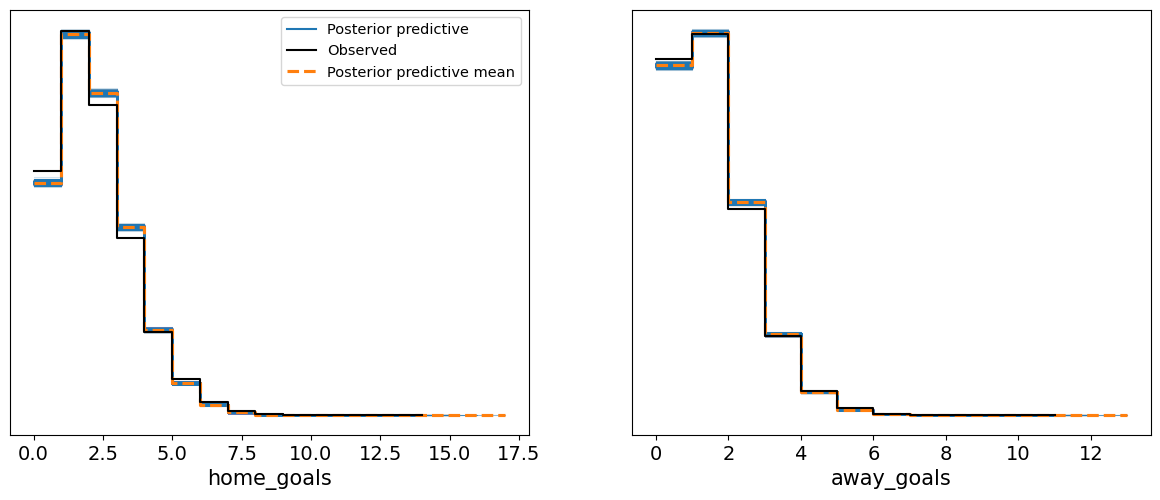

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace_rq3, model=model_rq3_final)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["home_goals"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((obs_h - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

Posterior Distributions and NUTS samples of Priors and Hyperpriors

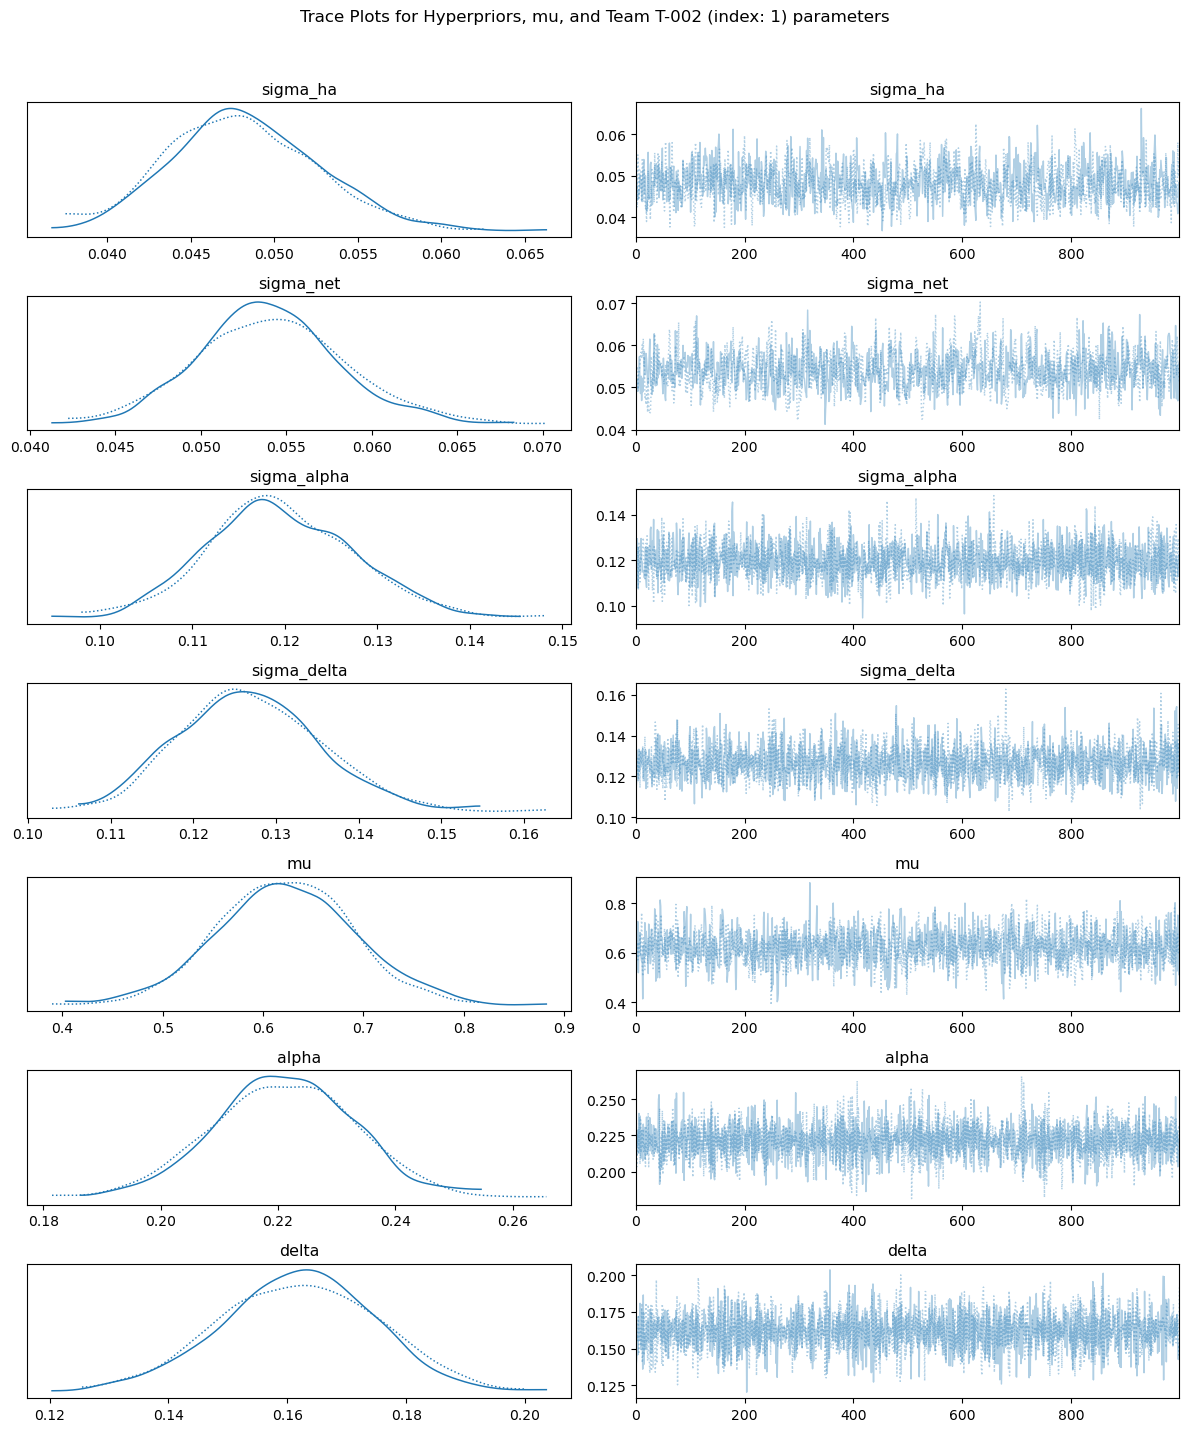

In [15]:
# Usually, we plot just the hyper-priors first so the screen isn't crowded
import matplotlib.pyplot as plt
import arviz as az

# Define the selected team's ID and get its index for plotting
selected_team_id = 'T-002' # Aston Villa
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    az.plot_trace(trace_rq3,
                  var_names=["sigma_ha", "sigma_net", "sigma_alpha", "sigma_delta", "mu", "alpha", "delta"],
                  coords={
                      "alpha_dim_0": [selected_team_index],
                      "delta_dim_0": [selected_team_index]
                  })
    plt.suptitle(f"Trace Plots for Hyperpriors, mu, and Team {selected_team_id} (index: {selected_team_index}) parameters", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")

Plotting trace for team: T-002 (index: 1)


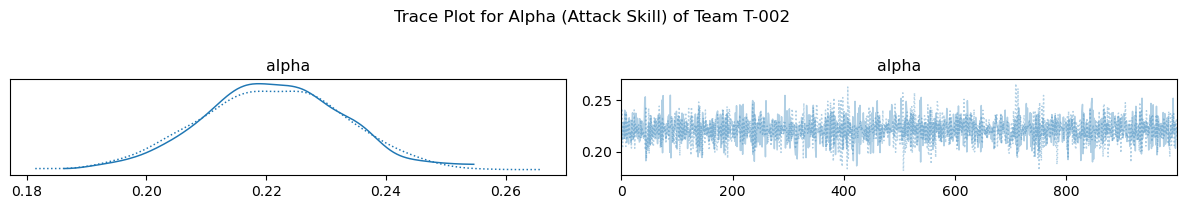

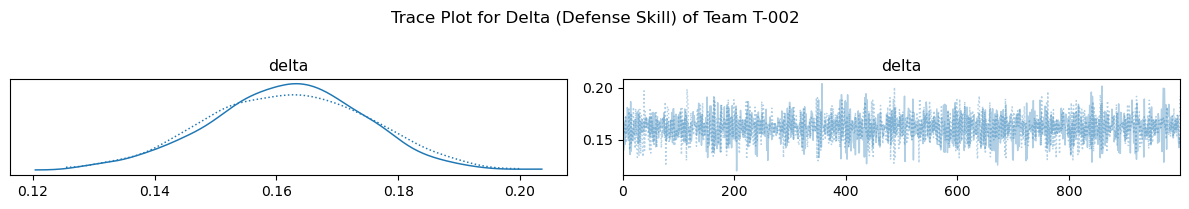

In [18]:
import matplotlib.pyplot as plt
import arviz as az

# Select a specific team (e.g., Aston Villa, which is 'T-002')
selected_team_id = 'T-002'
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    print(f"Plotting trace for team: {selected_team_id} (index: {selected_team_index})")

    # Plot trace for alpha of the selected team
    az.plot_trace(trace_rq3, var_names=["alpha"], coords={"alpha_dim_0": [selected_team_index]})
    plt.suptitle(f"Trace Plot for Alpha (Attack Skill) of Team {selected_team_id}", y=1.02) # Adjust suptitle position
    plt.tight_layout()
    plt.show()

    # Plot trace for delta of the selected team
    az.plot_trace(trace_rq3, var_names=["delta"], coords={"delta_dim_0": [selected_team_index]})
    plt.suptitle(f"Trace Plot for Delta (Defense Skill) of Team {selected_team_id}", y=1.02) # Adjust suptitle position
    plt.tight_layout()
    plt.show()
else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")

Plotting trace for net_curve and ha_curve for season 1966 (index: 67)


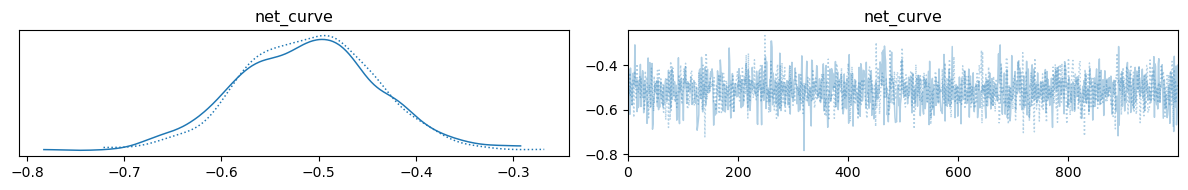

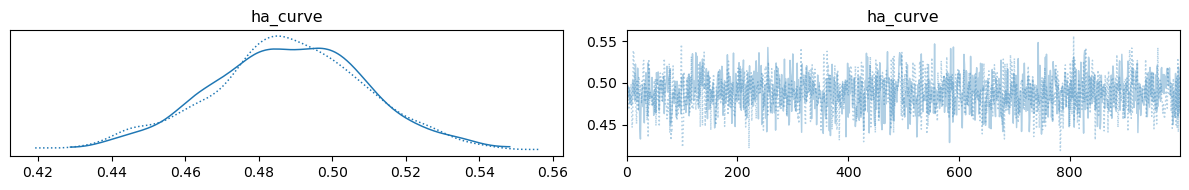

In [19]:
# Get the index for the year 1966
year_to_plot = 1966
year_idx = seasons.index(year_to_plot)

print(f"Plotting trace for net_curve and ha_curve for season {year_to_plot} (index: {year_idx})")

# Plot trace for net_curve for the selected season
az.plot_trace(trace_rq3, var_names=["net_curve"], coords={"net_curve_dim_0": [year_idx]})
# plt.suptitle(f"Trace Plot for Global Net Curve in Season {year_to_plot}", y=1.02)
plt.tight_layout()
plt.show()

# Plot trace for ha_curve for the selected season
az.plot_trace(trace_rq3, var_names=["ha_curve"], coords={"ha_curve_dim_0": [year_idx]})
# plt.suptitle(f"Trace Plot for Home Advantage Curve in Season {year_to_plot}", y=1.02)
plt.tight_layout()
plt.show()

Convergence Diagnostics

In [20]:
import arviz as az

# Get the index for team 'T-002'
selected_team_id = 'T-002'
selected_team_index = team_map.get(selected_team_id)

if selected_team_index is not None:
    # 1. Summary for all hyperpriors
    print("\nSummary Statistics for all Hyperpriors:")
    summary_hyperpriors = az.summary(
        trace_rq3,
        var_names=[
            "mu",
            "sigma_alpha",
            "sigma_delta",
            "sigma_ha",
            "sigma_net",
        ]
    )
    display(summary_hyperpriors)

    # 2. Summary for alpha and delta of the selected team
    print(f"\nSummary Statistics for Alpha and Delta of Team {selected_team_id} (index: {selected_team_index}):")
    summary_team_specific = az.summary(
        trace_rq3,
        var_names=["alpha", "delta"],
        coords={"alpha_dim_0": [selected_team_index], "delta_dim_0": [selected_team_index]}
    )
    display(summary_team_specific)

    # 3. Summary for ha_curve and net_curve for a particular season (e.g., 1966)
    selected_year = 1966
    year_idx = seasons.index(selected_year)
    print(f"\nSummary Statistics for ha_curve and net_curve in season {selected_year} (index: {year_idx}):")
    summary_curves_for_season = az.summary(
        trace_rq3,
        var_names=["ha_curve", "net_curve"],
        coords={
            "ha_curve_dim_0": [year_idx],
            "net_curve_dim_0": [year_idx]
        }
    )
    display(summary_curves_for_season)

else:
    print(f"Team ID '{selected_team_id}' not found in team_map.")


Summary Statistics for all Hyperpriors:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.622,0.067,0.499,0.757,0.002,0.001,1748.0,1279.0,1.0
sigma_alpha,0.120,0.008,0.104,0.133,0.000,0.000,2448.0,1536.0,1.0
sigma_delta,0.127,0.008,0.112,0.143,0.000,0.000,2301.0,1527.0,1.0
sigma_ha,0.048,0.004,0.041,0.057,0.000,0.000,933.0,1358.0,1.0
sigma_net,0.054,0.004,0.047,0.063,0.000,0.000,721.0,904.0,1.0



Summary Statistics for Alpha and Delta of Team T-002 (index: 1):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[1],0.221,0.012,0.199,0.245,0.0,0.0,4229.0,1294.0,1.0
delta[1],0.162,0.013,0.137,0.187,0.0,0.0,4505.0,1418.0,1.0



Summary Statistics for ha_curve and net_curve in season 1966 (index: 67):


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ha_curve[67],0.488,0.021,0.445,0.527,0.000,0.000,1899.0,1622.0,1.0
net_curve[67],-0.511,0.069,-0.637,-0.376,0.002,0.001,1799.0,1445.0,1.0


## Results

Evolution of Era Effect

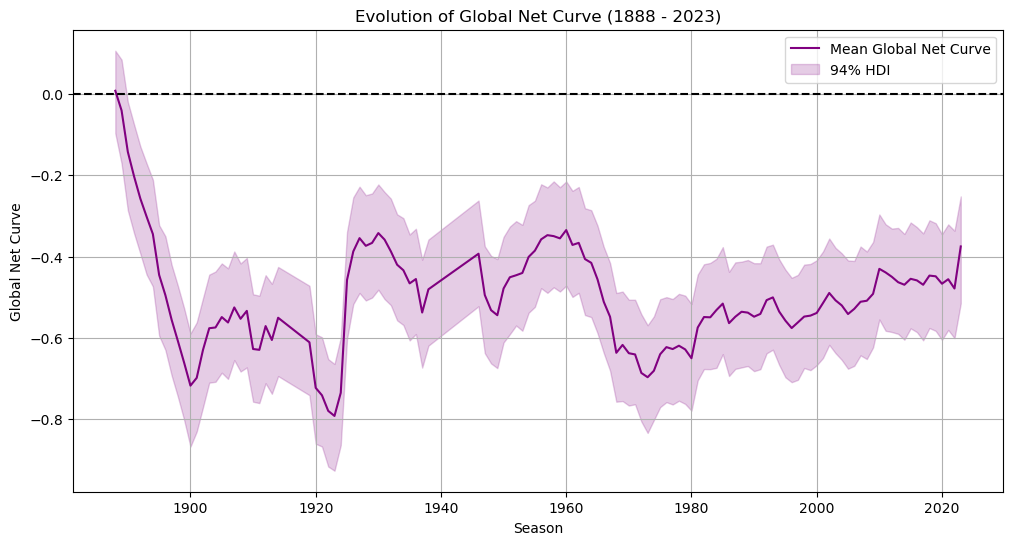

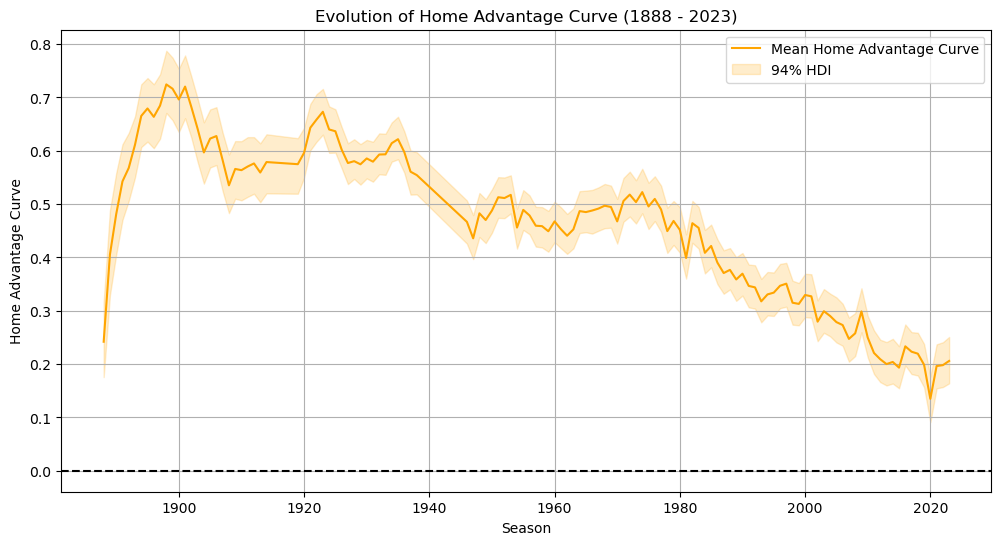

In [16]:
import matplotlib.pyplot as plt
import arviz as az

# Extract the posterior mean for the net curve
post_net_curve = trace_rq3.posterior["net_curve"].mean(dim=["chain", "draw"])
hdi_net_curve = az.hdi(trace_rq3, var_names=["net_curve"])['net_curve']

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_net_curve, label="Mean Global Net Curve", color="purple")
plt.fill_between(seasons, hdi_net_curve[:, 0], hdi_net_curve[:, 1], color="purple", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Global Net Curve (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Global Net Curve")
plt.legend()
plt.grid(True)
plt.show()

# Extract the posterior mean for the home advantage curve
post_ha_curve = trace_rq3.posterior["ha_curve"].mean(dim=["chain", "draw"])
hdi_ha_curve = az.hdi(trace_rq3, var_names=["ha_curve"])['ha_curve']

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha_curve, label="Mean Home Advantage Curve", color="orange")
plt.fill_between(seasons, hdi_ha_curve[:, 0], hdi_ha_curve[:, 1], color="orange", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage Curve (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home Advantage Curve")
plt.legend()
plt.grid(True)
plt.show()

Attributed Variance

In [21]:
import numpy as np

# Variance of ha_curve (Home Advantage Trend)
ha_curve_samples = trace_rq3.posterior['ha_curve'].values.flatten()
var_ha_curve = np.var(ha_curve_samples)
print(f"Variance of ha_curve (Home Advantage Trend): {var_ha_curve:.4f}")

# Variance of net_curve (Global Scoring Trend)
net_curve_samples = trace_rq3.posterior['net_curve'].values.flatten()
var_net_curve = np.var(net_curve_samples)
print(f"Variance of net_curve (Global Scoring Trend): {var_net_curve:.4f}")

# Variance of alpha (Team-specific Attack Offsets)
alpha_samples = trace_rq3.posterior['alpha'].values.flatten()
var_alpha = np.var(alpha_samples)
print(f"Variance of alpha (Team-specific Attack Offsets): {var_alpha:.4f}")

# Variance of delta (Team-specific Defense Offsets)
delta_samples = trace_rq3.posterior['delta'].values.flatten()
var_delta = np.var(delta_samples)
print(f"Variance of delta (Team-specific Defense Offsets): {var_delta:.4f}")

Variance of ha_curve (Home Advantage Trend): 0.0218
Variance of net_curve (Global Scoring Trend): 0.0216
Variance of alpha (Team-specific Attack Offsets): 0.0140
Variance of delta (Team-specific Defense Offsets): 0.0157
